In [ ]:
%pip install pandas matplotlib numpy tables vitables scipy
;

# Работа с массивами данных при помощи Pandas

Нам понадобится `pip install pandas scipy tables vitables`.

*Возможно `tables` потребуется установить вручную:*

1. https://www.lfd.uci.edu/~gohlke/pythonlibs/#pytables
2. Скачать `.whl`
3. `pip install xxxxxxxxxxxxx.whl`
4. Повторить всё из "нам понадобится"

Из дополнительных материалов рекомендуется этот текст: https://khashtamov.com/ru/pandas-introduction/

Мы немножко попробуем, как [Карлсон](https://web.archive.org/web/20190305185555if_/https://cs10.pikabu.ru/post_img/2018/07/10/4/1531199339121474094.jpg).

Будем сразу играть за две стороны. Точнее за три. За хорошего математика, за плохого математика и за себя.

In [2]:
from IPython.display import display, Markdown

ntries = 100
throws = 25

display(Markdown(
f"""
## Хороший математик

Откуда-то взял числа, нормально распределённые. Наверное он [кидал монетку {ntries} раз по {throws} бросков](https://ru.wikipedia.org/wiki/%D0%A6%D0%B5%D0%BD%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%82%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0) и каждый раз записывал среднее количество орлов.
"""
))


## Хороший математик

Откуда-то взял числа, нормально распределённые. Наверное он [кидал монетку 100 раз по 25 бросков](https://ru.wikipedia.org/wiki/%D0%A6%D0%B5%D0%BD%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%82%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0) и каждый раз записывал среднее количество орлов.


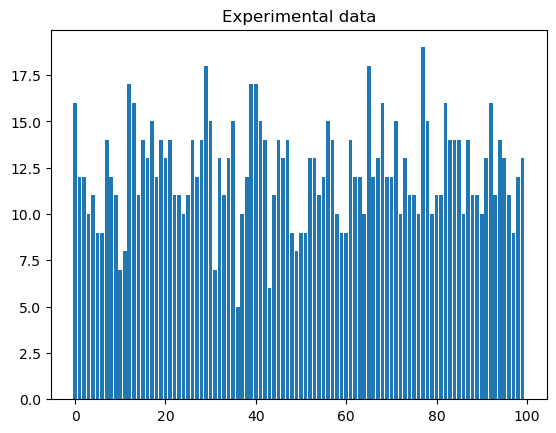

In [3]:
%matplotlib inline  

import pandas
import random

import matplotlib
import numpy
import matplotlib.pyplot as plt

rgen = random.Random()

experiments = []
for e in range(ntries):
    v = 0
    for r in range(throws):
        v += rgen.randint(0, 1)
    experiments.append(v)

# plt.plot(list(range(ntries)), experiments)
plt.bar(list(range(ntries)), experiments)
plt.title('Experimental data')
plt.show()

Эти данные нам прислал хороший математик. Для этого он воспользовался форматом CSV.

In [4]:
import pandas

df = pandas.DataFrame(data={
    'experiments': experiments
})

df.to_csv("experiments.csv")

## Плохой математик

Где-то получил эти данные, запортил их, и, чтобы мы его не очень ассоциировали с хорошим, отправил данные в формате HDF5

In [5]:
df.loc[df.experiments % 4 == 0, 'experiments'] = 0
df.loc[df.experiments % 4 == 1, 'experiments'] = throws
df.to_hdf("experiments.h5", "experiments")

/tmp/ipykernel_892127/3241452329.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf("experiments.h5", "experiments")


... посмотрел при помощи ViTables, мерзко захихикал и тоже нам отправил.

## Мы

Получили два набора данных, подозреваем, что что-то не так, но не знаем, какой из них хороший, а какой плохой.

<Axes: >

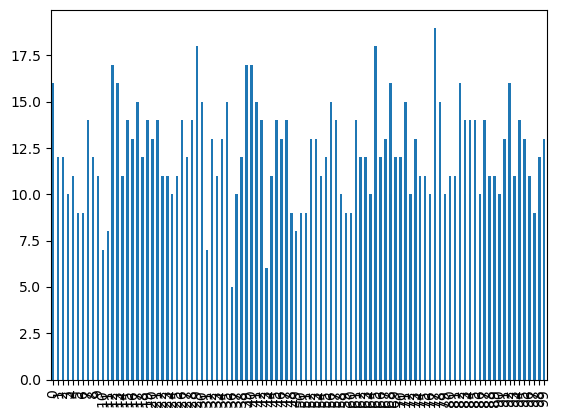

In [6]:
try:
    del df
except:
    pass

df1 = pandas.read_csv("experiments.csv")
df2 = pandas.read_hdf("experiments.h5")

df1['experiments'].plot(kind='bar')

<Axes: >

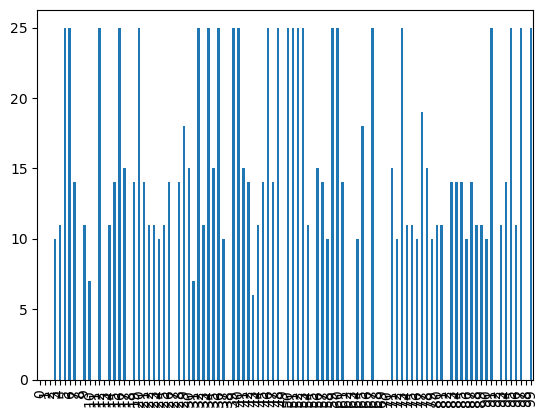

In [7]:
df2['experiments'].plot(kind='bar')

Что-то и правда не сходится. Посмотрим на *плотность распределения*...

In [8]:
print(df1.experiments.describe())
print(df2.experiments.describe())

count    100.000000
mean      12.270000
std        2.666117
min        5.000000
25%       11.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: experiments, dtype: float64
count    100.000000
mean      12.910000
std        8.554159
min        0.000000
25%       10.000000
50%       12.500000
75%       18.250000
max       25.000000
Name: experiments, dtype: float64


<Axes: ylabel='Density'>

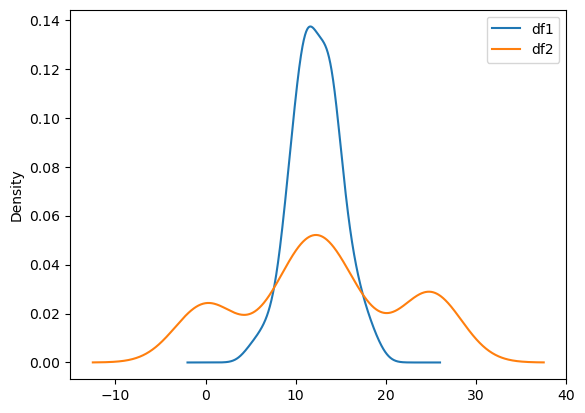

In [9]:
df12 = pandas.DataFrame(data={
    'df1': df1['experiments'],
    'df2': df2['experiments'],
})

df12.plot.kde()

Что-то с `df2` с виду не похож ни на [распределение Стьюдента](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D1%82%D1%8C%D1%8E%D0%B4%D0%B5%D0%BD%D1%82%D0%B0), ни на [нормальное распределение](https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5), хотя должен бы...

А мы можем это оценить численно, или нет? Можем. При помощи критерия Колмогорова-Смирнова.

Гипотеза: данное распределение близко к нормальному.

В результате проверки вычисляются два числа — *К-С-статистика* и *P-значение*. Если первое мало или второе велико, мы гипотезу отвергнуть не можем. В противном случае, гипотеза может считаться ошибочной.

In [10]:
from scipy import stats

d1 = df12['df1']
d2 = df12['df2']

#print(stats.kstest('norm', 'norm', N=3))
#print(stats.kstest('norm', 'norm', N=5000))
print("Сравним d1 (хорошие данные) и d2 (плохие)")
print(stats.kstest(d1, d2))
print()

# If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
print("Сравним с распределением Гаусса")
print(stats.kstest(d1, 'norm', (d1.mean(), d1.std()), N=len(d1)))
print(stats.kstest(d2, 'norm', (d2.mean(), d2.std()), N=len(d2)))
print()

print(f"Сравним с распределением Стьюдента c {throws} степенями свободы")
print(stats.kstest(d1, 't', (throws, d1.mean(), d1.std()), N=len(d1)))
print(stats.kstest(d2, 't', (throws, d2.mean(), d2.std()), N=len(d2)))

Сравним d1 (хорошие данные) и d2 (плохие)
KstestResult(statistic=np.float64(0.24), pvalue=np.float64(0.0061340334218580265), statistic_location=np.int64(17), statistic_sign=np.int8(1))

Сравним с распределением Гаусса
KstestResult(statistic=np.float64(0.09308680618964943), pvalue=np.float64(0.33089587094019646), statistic_location=np.int64(11), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.16122322586564564), pvalue=np.float64(0.00973132302378245), statistic_location=np.int64(25), statistic_sign=np.int8(-1))

Сравним с распределением Стьюдента c 25 степенями свободы
KstestResult(statistic=np.float64(0.09101835294864269), pvalue=np.float64(0.3571972655582927), statistic_location=np.int64(11), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.15505770087900073), pvalue=np.float64(0.014484713362363066), statistic_location=np.int64(25), statistic_sign=np.int8(-1))


Видим, что для первого распределения *К-С-статистика* ниже, чем для второго, но не намного. Зато *P-значение* для первого заметно выше. Т.е. первое ближе к Стьюдента и нормальному.